In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
from scipy import stats

import numpy as np
import ast,json,glob,os


In [2]:
from matplotlib.offsetbox import bbox_artist


def load_df(fname):
    df = pd.read_csv(fname)
    
    df["SN Undiagnosed"] = df["SN Untreated chronic"].values + df["SN Untreated acute"].values
    df["CN Undiagnosed"] = df["CN Untreated chronic"].values + df["CN Untreated acute"].values
    
    df["SN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["SN sampled"],df["SN seed"])] #df.apply(lambda x: x["SN sampled"].len())
    df["CN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["CN sampled"],df["CN seed"])]
    
    return df


def get_confidence_intervals(raw_data):
    # raw_data is a list of counts
    raw_data = list(raw_data)
    vals = list(set(raw_data))
    probs = []
    for v in vals:
        probs.append(raw_data.count(v)/len(raw_data))
    custom_dist = stats.rv_discrete(values=(vals,probs))
    interval = custom_dist.interval(0.95)
    return np.median(raw_data),interval


def print_CIs(fname):
    df = load_df(fname)
    df = df.dropna()
    columns = ["SN sample size","SN HIV+","SN Out-of-care","SN Undiagnosed","CN sample size","CN HIV+","CN Out-of-care","CN Undiagnosed"]
    
    for col in columns:
        vals = df[col].values
        median,confint = get_confidence_intervals(vals)
        print("{}: {}, {}".format(col,median,confint))
    
    print("\n\n")

    for col in ["SN GN count","CN GN count","SN TN count","CN TN count"]:
        vals = df[col].values
        median,confint = get_confidence_intervals(vals)
        print("{}: {}, {}".format(col,median,confint))


def make_CI_array(fnames,col,pop_col):
    CI_array_lower = []
    CI_array_upper = []
    for fname in fnames:
        df = load_df(fname)
        df = df.dropna()
        vals = df[col].values
        median,confint = get_confidence_intervals(vals)
        denom = np.median(df[pop_col].values)
        CI_array_lower.append(median/denom - confint[0]/denom)
        CI_array_upper.append(confint[1]/denom -median/denom)
    return np.array([CI_array_lower,CI_array_upper])


def plot_gn_tn(fname,savename,plotylim):
    df = load_df(fname)
    # Plot 1
    box=df.boxplot(column=["SN GN count","CN GN count","SN TN count","CN TN count"],positions=[1,2,3,4],patch_artist=True,medianprops=dict(color="k"),whiskerprops=dict(color="k"),capprops=dict(color="k"),notch=True,return_type='both')
    colors = ['blue','red','blue','red']
    for patch,color in zip(box[1]["boxes"],colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("k")
    plt.ylim(plotylim)
    plt.ylabel("Number of pairs")
    plt.xticks(ticks=[1,2,3,4], labels=["SNS GN","SPCT GN","SNS TN","SPCT TN"])
    # Create custom handles for the legend
    handle1 = mpatches.Patch(color='b', label='SNS')
    handle2 = mpatches.Patch(color='r', label='SPCT')
    plt.legend(handles=[handle1, handle2])
    try:
        plt.savefig(savename,bbox_inches="tight", dpi=600)
    except:
        plt.savefig(savename,bbox_inches="tight")
    plt.show()


def plot_comps(fname,savename,tag="orig"):
    df = load_df(fname)
    # Plot 2
    box = df.boxplot(column=["SN sample size","SN HIV+","SN Out-of-care","SN Undiagnosed"],patch_artist=True,medianprops=dict(color="k"),whiskerprops=dict(color="k"),capprops=dict(color="k"),boxprops=dict(color="b"),notch=True,return_type="both")
    df.boxplot(column=["CN sample size","CN HIV+","CN Out-of-care","CN Undiagnosed"],patch_artist=True,medianprops=dict(color="k"),whiskerprops=dict(color="k"),flierprops=dict(color="k"),meanprops=dict(color="k"),capprops=dict(color="k"),boxprops=dict(color="r"),notch=True,ax=box[0])
    plt.xticks(ticks=[1,2,3,4], labels=["Sample","PLWH","OoC","UD"])
    plt.ylim([0,625])
    if tag=="orig":
        plt.text(1,550,"100%")
        plt.text(1,75,"100%")
        plt.text(2,300,"47.5%")
        plt.text(2,50,"48.4%")
        plt.text(3,210,"29.4%")
        plt.text(3,40,"29.0%")
        plt.text(4,60,"5.9%")
        plt.text(4.25,8,"6.5%")
    elif tag=="contact":
        plt.text(1,550,"100%")
        plt.text(1,100,"100%")
        plt.text(2,300,"47.8%")
        plt.text(2,60,"50.0%")
        plt.text(3,210,"29.8%")
        plt.text(3,40,"31.0%")
        plt.text(4,60,"5.9%")
        plt.text(4.25,8,"7.1%")

    plt.ylabel("Number of individuals")
    # Create custom handles for the legend
    handle1 = mpatches.Patch(color='b', label='SNS')
    handle2 = mpatches.Patch(color='r', label='SPCT')
    plt.legend(handles=[handle1, handle2])
    try:
        plt.savefig(savename,bbox_inches="tight", dpi=600)
    except:
        plt.savefig(savename,bbox_inches="tight")
    plt.show()

def boxplots(fname,savename1,savename2,plot1ylim=(0,40),tag="orig"):
    plot_gn_tn(fname,savename1,plot1ylim)
    plot_comps(fname,savename2,tag=tag)
    

def percentages(fname):
    df = load_df(fname)
    print("Number of rows with NaN: {}".format(df.shape[0] - df.dropna().shape[0]))
    df = df.dropna()
    SNdenom = np.median(df["SN sample size"].values)
    CNdenom = np.median(df["CN sample size"].values)
    SNhiv = np.median(df["SN HIV+"].values)
    CNhiv = np.median(df["CN HIV+"].values)
    SNooc = np.median(df["SN Out-of-care"].values)
    CNooc = np.median(df["CN Out-of-care"].values)
    SNud = np.median(df["SN Undiagnosed"].values)
    CNud = np.median(df["CN Undiagnosed"].values)
    props = {"SNS sample size" : SNdenom, "SPCT sample size" : CNdenom, "SNS PLWH" : SNhiv/SNdenom,"SNS OoC" : SNooc/SNdenom,"SNS UD" : SNud/SNdenom,"SPCT PLWH" : CNhiv/CNdenom,"SPCT OoC" : CNooc/CNdenom,"SPCT UD" : CNud/CNdenom}
    return props
    

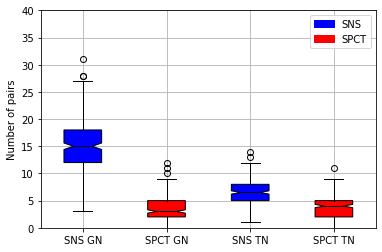

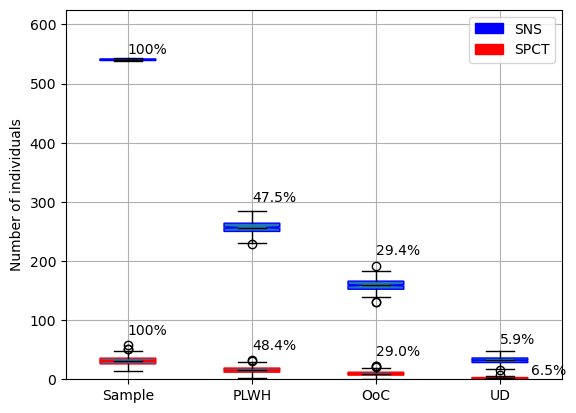

Number of rows with NaN: 0
SNS sample size: 540.0
SPCT sample size: 31.0
SNS PLWH: 0.475
SNS OoC: 0.29444444444444445
SNS UD: 0.05925925925925926
SPCT PLWH: 0.4838709677419355
SPCT OoC: 0.2903225806451613
SPCT UD: 0.06451612903225806



SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 256.5, (234.0, 279.0)
SN Out-of-care: 159.0, (142.0, 177.0)
SN Undiagnosed: 32.0, (21.0, 43.0)
CN sample size: 31.0, (18.0, 46.0)
CN HIV+: 15.0, (7.0, 27.0)
CN Out-of-care: 9.0, (3.0, 18.0)
CN Undiagnosed: 2.0, (0.0, 5.0)



SN GN count: 15.0, (6.0, 25.0)
CN GN count: 3.0, (0.0, 8.0)
SN TN count: 6.5, (2.0, 11.0)
CN TN count: 4.0, (0.0, 8.0)


In [3]:
fname100 = "results_trimmed_end/JOB758832/all_summaries_20221031.csv"
boxplots(fname100,"results_trimmed_end/JOB758832/gn_tn_edges_20221031_end.jpg","results_trimmed_end/JOB758832/compartments_20221031_end.jpg")
p_100 = percentages(fname100)
for key,val in p_100.items():
    print(key+": "+str(val))

print("\n\n")
print_CIs(fname100)


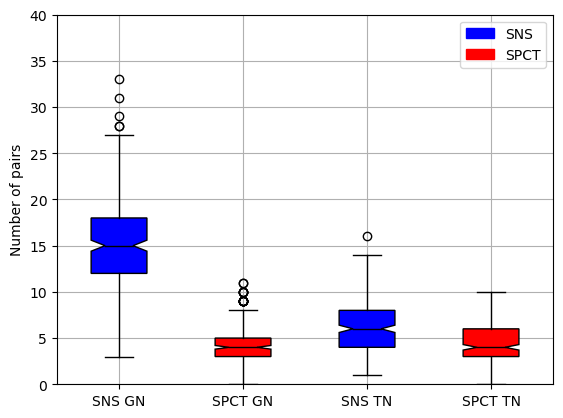

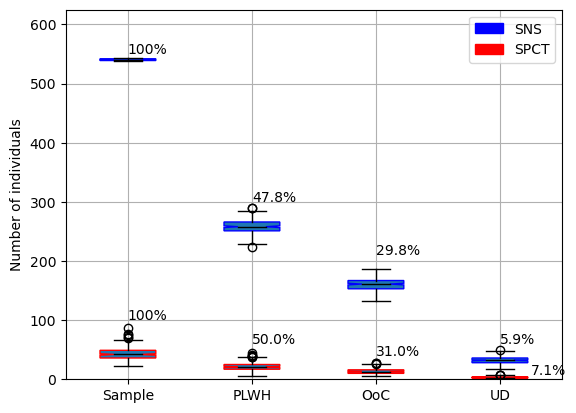

Number of rows with NaN: 0
SNS sample size: 540.0
SPCT sample size: 42.0
SNS PLWH: 0.4777777777777778
SNS OoC: 0.29814814814814816
SNS UD: 0.05925925925925926
SPCT PLWH: 0.5
SPCT OoC: 0.30952380952380953
SPCT UD: 0.07142857142857142



SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 258.0, (239.0, 280.0)
SN Out-of-care: 161.0, (142.0, 181.0)
SN Undiagnosed: 32.0, (22.0, 44.0)
CN sample size: 42.0, (24.0, 65.0)
CN HIV+: 21.0, (11.0, 37.0)
CN Out-of-care: 13.0, (6.0, 23.0)
CN Undiagnosed: 3.0, (0.0, 7.0)



SN GN count: 15.0, (6.0, 27.0)
CN GN count: 4.0, (1.0, 10.0)
SN TN count: 6.0, (2.0, 12.0)
CN TN count: 4.0, (1.0, 9.0)


In [4]:
fname = "results_trimmed_end/JOB758832_RDS_contact/all_summaries_20221031contact.csv"
boxplots(fname,"results_trimmed_end/JOB758832_RDS_contact/gn_tn_edges_20221031_end_contact.jpg","results_trimmed_end/JOB758832_RDS_contact/compartments_20221031_end_contact.jpg",tag="contact")
props_100 = percentages(fname)
for key,val in props_100.items():
    print(key+": "+str(val))

print("\n\n")
print_CIs(fname)

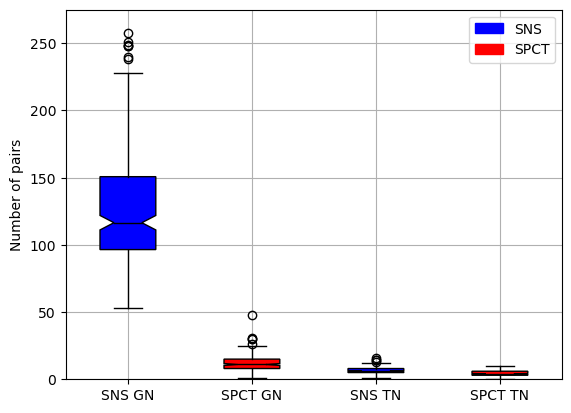

SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 257.0, (233.0, 280.0)
SN Out-of-care: 159.0, (140.0, 179.0)
SN Undiagnosed: 32.0, (23.0, 44.0)
CN sample size: 32.0, (19.0, 46.0)
CN HIV+: 17.0, (8.0, 29.0)
CN Out-of-care: 10.0, (4.0, 17.0)
CN Undiagnosed: 2.0, (0.0, 6.0)



SN GN count: 116.5, (66.0, 240.0)
CN GN count: 11.0, (4.0, 23.0)
SN TN count: 6.0, (2.0, 11.0)
CN TN count: 4.0, (1.0, 9.0)


In [5]:
fname = "results_trimmed_infection/JOB784278/all_summaries_20221118_infection.csv"
plot_gn_tn(fname,"results_trimmed_infection/JOB784278/gn_tn_edges_20221118_infection.jpg",plotylim=(0,275))

print_CIs(fname)



sensitivity_analysis_acceptance/acceptance00/all_summaries_20221120160058.csv
sensitivity_analysis_acceptance/acceptance02/all_summaries_20221120160746.csv
sensitivity_analysis_acceptance/acceptance04/all_summaries_20221120161907.csv
sensitivity_analysis_acceptance/acceptance06/all_summaries_20221120163504.csv
sensitivity_analysis_acceptance/acceptance08/all_summaries_20221120164621.csv
sensitivity_analysis_acceptance/acceptance10/all_summaries_20221120165242.csv


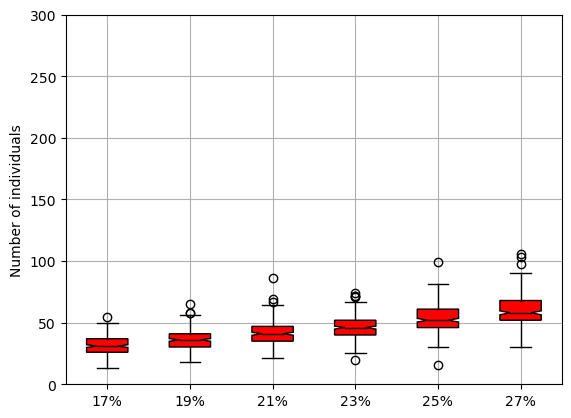

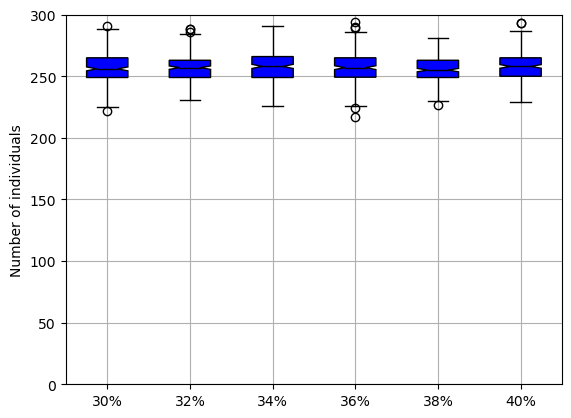




SPCT sample size, 17%: 31.0, (19.0, 47.0)
SPCT sample size, 19%: 36.0, (21.0, 52.0)
SPCT sample size, 21%: 41.0, (25.0, 59.0)
SPCT sample size, 23%: 46.0, (28.0, 66.0)
SPCT sample size, 25%: 52.0, (35.0, 76.0)
SPCT sample size, 27%: 58.0, (35.0, 84.0)



SNS PLWH, 30%: 256.0, (233.0, 282.0)
SNS PLWH, 32%: 257.0, (236.0, 280.0)
SNS PLWH, 34%: 258.0, (237.0, 280.0)
SNS PLWH, 36%: 257.0, (233.0, 283.0)
SNS PLWH, 38%: 255.0, (233.0, 277.0)
SNS PLWH, 40%: 258.0, (235.0, 280.0)


In [6]:
f = lambda d : glob.glob(os.path.join(os.path.join("sensitivity_analysis_acceptance",d),"all_summaries*"))[0]
fnames = [f("acceptance00"),f("acceptance02"),f("acceptance04"),f("acceptance06"),f("acceptance08"),f("acceptance10")]
cn_nums = ["17%","19%","21%","23%","25%","27%"]
cn_size = pd.DataFrame()
sn_nums = list(reversed(["40%", "38%", "36%", "34%","32%","30%"]))
sn_hiv = pd.DataFrame()
for n,m,fname in zip(cn_nums,sn_nums,fnames):
    print(fname)
    # plot_comps(fname,os.path.join(os.path.split(fname)[0],"compartments_20221120.jpg"))
    df = load_df(fname)
    cn_size[n] = df["CN sample size"].values
    sn_hiv[m] = df["SN HIV+"].values
cn_size.boxplot(column=cn_nums,patch_artist=True,medianprops=dict(color="k"),whiskerprops=dict(color="k"),flierprops=dict(color="k"),meanprops=dict(color="k"),capprops=dict(color="k"),boxprops=dict(facecolor="r"),notch=True)
plt.ylabel("Number of individuals")
plt.ylim(0,300)
plt.savefig("sensitivity_analysis_acceptance/cn_size.jpg",bbox_inches="tight", dpi=600)
plt.show()
sn_hiv.boxplot(column=sn_nums,patch_artist=True,medianprops=dict(color="k"),whiskerprops=dict(color="k"),flierprops=dict(color="k"),meanprops=dict(color="k"),capprops=dict(color="k"),boxprops=dict(facecolor="b"),notch=True)
plt.ylabel("Number of individuals")
plt.ylim(0,300)
plt.savefig("sensitivity_analysis_acceptance/sn_hiv_pos.jpg",bbox_inches="tight", dpi=600)
plt.show()

print("\n\n")
for k in cn_nums:
    median,confint = get_confidence_intervals(cn_size[k].values)
    print("SPCT sample size, {}: {}, {}".format(k,median,confint))
print("\n\n")
for k in sn_nums:
    median,confint = get_confidence_intervals(sn_hiv[k].values)
    print("SNS PLWH, {}: {}, {}".format(k,median,confint))


In [7]:
fname75 = "results_trimmed_75prevalence/JOB913797/all_summaries_75prevalence.csv"
# boxplots(fname,"results_trimmed_75prevalence/JOB913797/gn_tn_edges_20221219_75prevalence.jpg","results_trimmed_75prevalence/JOB913797/compartments_20221219_75prevalence.jpg")
props_75 = percentages(fname75)
for key,val in props_75.items():
    print(key+": "+str(val))

# print confidence intervals
print("\n\n")
print_CIs(fname75)



Number of rows with NaN: 2
SNS sample size: 540.0
SPCT sample size: 30.0
SNS PLWH: 0.37407407407407406
SNS OoC: 0.22777777777777777
SNS UD: 0.05185185185185185
SPCT PLWH: 0.4666666666666667
SPCT OoC: 0.26666666666666666
SPCT UD: 0.06666666666666667



SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 202.0, (181.0, 226.0)
SN Out-of-care: 123.0, (106.0, 140.0)
SN Undiagnosed: 28.0, (19.0, 38.0)
CN sample size: 30.0, (20.0, 47.0)
CN HIV+: 14.0, (7.0, 25.0)
CN Out-of-care: 8.0, (3.0, 15.0)
CN Undiagnosed: 2.0, (0.0, 6.0)



SN GN count: 13.0, (5.0, 24.0)
CN GN count: 4.0, (0.0, 9.0)
SN TN count: 6.0, (2.0, 11.0)
CN TN count: 4.5, (1.0, 10.0)


In [8]:
fname50 = "results_trimmed_50prevalence/JOB916185/all_summaries_50prevalence_20221220.csv"
# boxplots(fname,"results_trimmed_50prevalence/JOB916185/gn_tn_edges_20221220_50prevalence.jpg","results_trimmed_50prevalence/JOB916185/compartments_20221220_50prevalence.jpg")
props_50 = percentages(fname50)
for key,val in props_50.items():
    print(key+": "+str(val))

# print confidence intervals
print("\n\n")
print_CIs(fname50)


Number of rows with NaN: 0
SNS sample size: 540.0
SPCT sample size: 31.0
SNS PLWH: 0.25925925925925924
SNS OoC: 0.1527777777777778
SNS UD: 0.040740740740740744
SPCT PLWH: 0.3548387096774194
SPCT OoC: 0.1935483870967742
SPCT UD: 0.06451612903225806



SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 140.0, (120.0, 160.0)
SN Out-of-care: 82.5, (66.0, 98.0)
SN Undiagnosed: 22.0, (14.0, 32.0)
CN sample size: 31.0, (17.0, 44.0)
CN HIV+: 11.0, (5.0, 20.0)
CN Out-of-care: 6.0, (2.0, 13.0)
CN Undiagnosed: 2.0, (0.0, 6.0)



SN GN count: 12.0, (5.0, 22.0)
CN GN count: 5.0, (1.0, 11.0)
SN TN count: 6.0, (2.0, 11.0)
CN TN count: 5.0, (1.0, 11.0)


In [9]:
fname25 = "results_trimmed_25prevalence/JOB916621/all_summaries_25prevalence_20221221.csv"
# boxplots(fname,"results_trimmed_25prevalence/JOB916621/gn_tn_edges_20221221_25prevalence.jpg","results_trimmed_25prevalence/JOB916621/compartments_20221221_25prevalence.jpg")
props_25 = percentages(fname25)
for key,val in props_25.items():
    print(key+": "+str(val))

# print confidence intervals
print("\n\n")
print_CIs(fname25)

Number of rows with NaN: 1
SNS sample size: 540.0
SPCT sample size: 28.0
SNS PLWH: 0.13518518518518519
SNS OoC: 0.07777777777777778
SNS UD: 0.024074074074074074
SPCT PLWH: 0.2857142857142857
SPCT OoC: 0.14285714285714285
SPCT UD: 0.07142857142857142



SN sample size: 540.0, (538.0, 543.0)
SN HIV+: 73.0, (56.0, 91.0)
SN Out-of-care: 42.0, (30.0, 55.0)
SN Undiagnosed: 13.0, (6.0, 21.0)
CN sample size: 28.0, (17.0, 41.0)
CN HIV+: 8.0, (2.0, 15.0)
CN Out-of-care: 4.0, (1.0, 9.0)
CN Undiagnosed: 2.0, (0.0, 5.0)



SN GN count: 9.0, (3.0, 18.0)
CN GN count: 6.0, (1.0, 14.0)
SN TN count: 5.0, (2.0, 9.0)
CN TN count: 5.0, (2.0, 11.0)


In [24]:

def make_bar_prev(SNScol,SPCTcol,props_100,props_75,props_50,props_25,SNS_CI,SPCT_CI,savename = "prevalence_plot.jpg"):
    # make bar graph from props_100, props_75, props_50, and props_25

    xticks = ["36.3%","27.2%","18.1%","9.1%"]

    # set height of bar to match xticks
    SNS = [props_100[SNScol],props_75[SNScol],props_50[SNScol],props_25[SNScol]]
    CT = [props_100[SPCTcol],props_75[SPCTcol],props_50[SPCTcol],props_25[SPCTcol]]

    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    
    # Set position of bar on X axis
    br1 = np.arange(len(SNS))
    br2 = [x + barWidth for x in br1]

    
    # Make the plot
    print(SNS)
    print(SNS_CI)
    print(CT)
    print(SPCT_CI)
    plt.bar(br1, SNS, yerr=SNS_CI,color ='b', width = barWidth,
        edgecolor ='k', label =SNScol)
    plt.bar(br2, CT, yerr=SPCT_CI,color ='r', width = barWidth,
        edgecolor ='k', label =SPCTcol)

        
    # Adding Xticks
    plt.xlabel('% HIV prevalence', fontsize = 16,fontweight='bold')
    plt.ylabel('Percentage of sampled population', fontsize = 16)
    plt.xticks([r + barWidth for r in range(len(SNS))],
            xticks)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim([0,0.90])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


    #make legend
    plt.legend(fontsize=16)

    # save figure
    try:
        plt.savefig(savename,bbox_inches="tight", dpi=600)
    except:
        plt.savefig(savename,bbox_inches="tight")

    plt.show()




[0.4777777777777778, 0.37407407407407406, 0.25925925925925924, 0.13518518518518519]
[[0.04166667 0.03888889 0.03703704 0.03148148]
 [0.04166667 0.04444444 0.03703704 0.03333333]]
[0.5, 0.4666666666666667, 0.3548387096774194, 0.2857142857142857]
[[0.25806452 0.23333333 0.19354839 0.21428571]
 [0.38709677 0.36666667 0.29032258 0.25      ]]


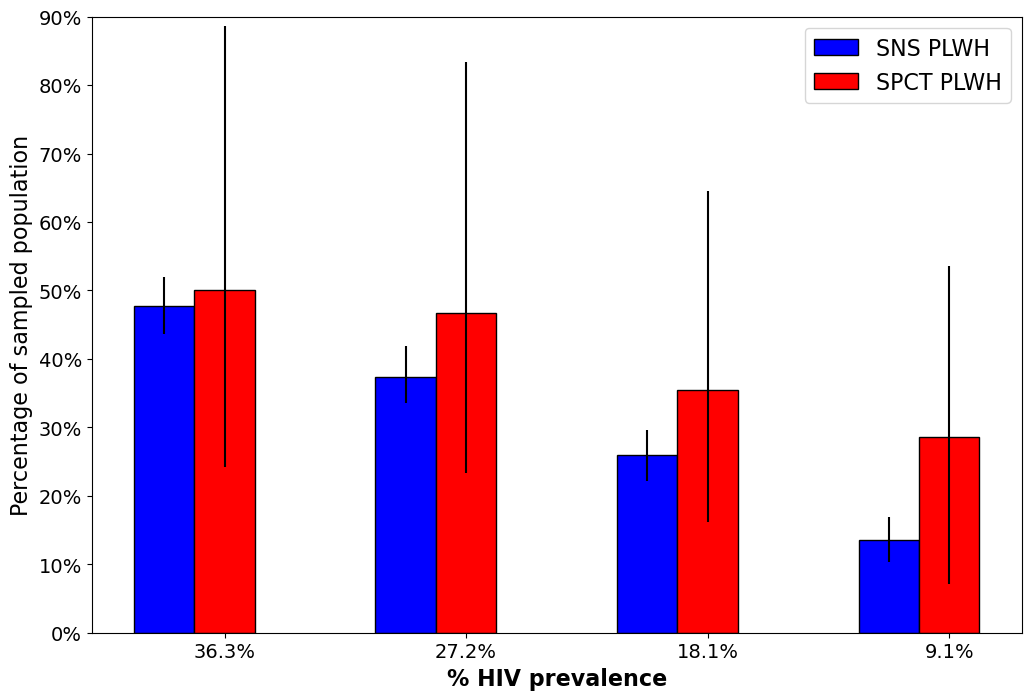

[0.29814814814814816, 0.22777777777777777, 0.1527777777777778, 0.07777777777777778]
[[0.03148148 0.03148148 0.03055556 0.02222222]
 [0.03333333 0.03148148 0.0287037  0.02407407]]
[0.30952380952380953, 0.26666666666666666, 0.1935483870967742, 0.14285714285714285]
[[0.19354839 0.16666667 0.12903226 0.10714286]
 [0.29032258 0.23333333 0.22580645 0.17857143]]


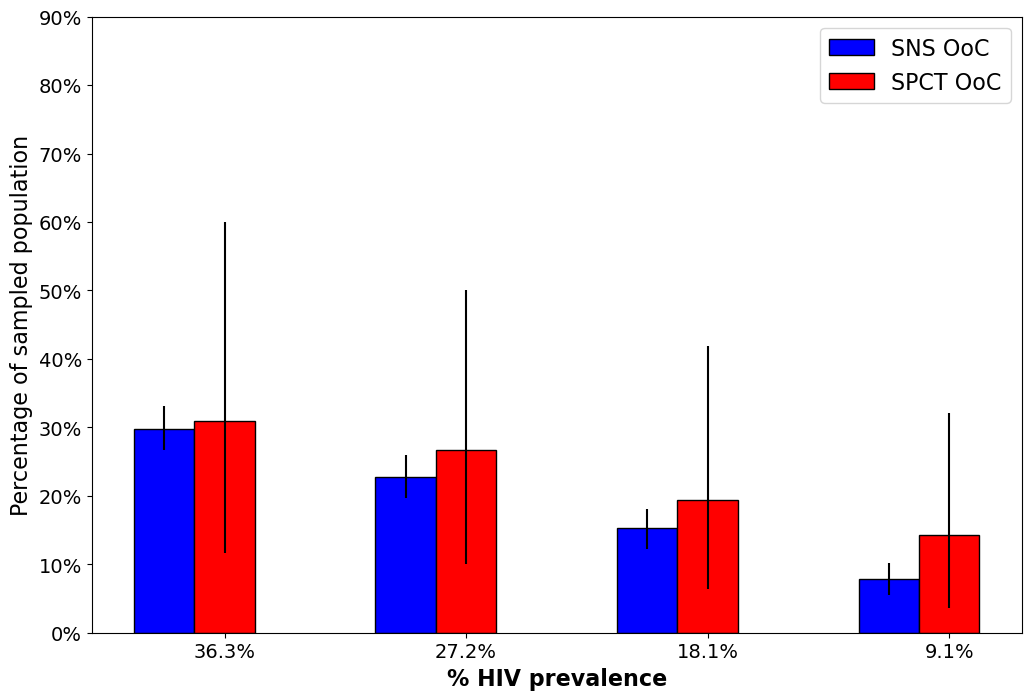

[0.05925925925925926, 0.05185185185185185, 0.040740740740740744, 0.024074074074074074]
[[0.02037037 0.01666667 0.01481481 0.01296296]
 [0.02037037 0.01851852 0.01851852 0.01481481]]
[0.07142857142857142, 0.06666666666666667, 0.06451612903225806, 0.07142857142857142]
[[0.06451613 0.06666667 0.06451613 0.07142857]
 [0.09677419 0.13333333 0.12903226 0.10714286]]


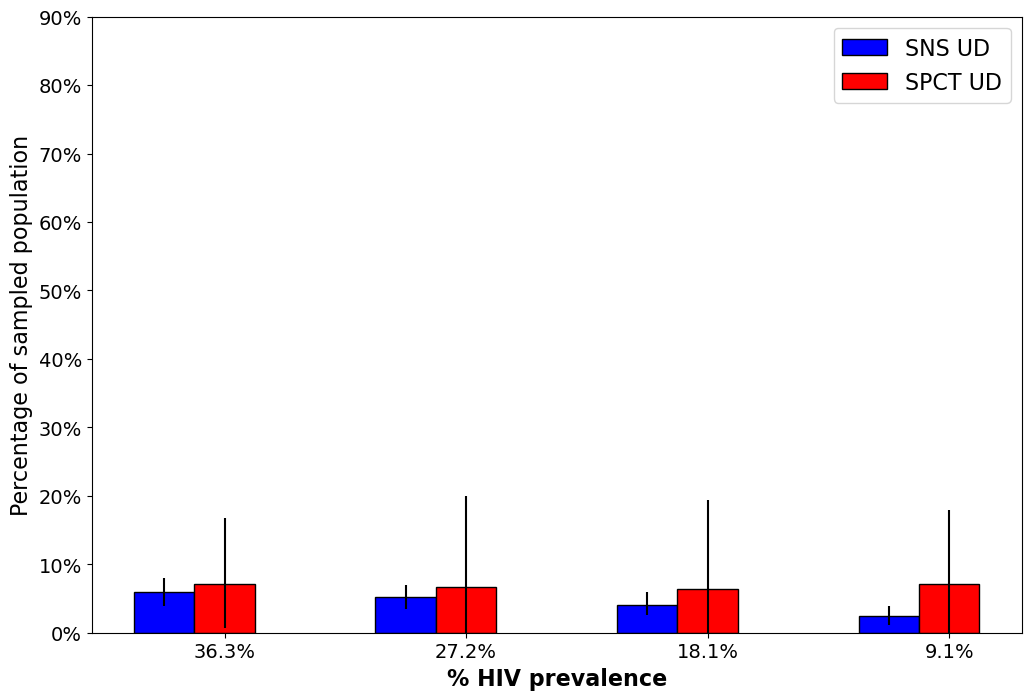

In [25]:

SNScol = "SNS PLWH"
SNS_CI = make_CI_array([fname100,fname75,fname50,fname25],"SN HIV+","SN sample size")
SPCTcol = "SPCT PLWH"
SPCT_CI = make_CI_array([fname100,fname75,fname50,fname25],"CN HIV+","CN sample size")
savename = "Fig5_panelA_prevalence_plot_PLWH.jpg"
make_bar_prev(SNScol,SPCTcol,props_100,props_75,props_50,props_25,SNS_CI,SPCT_CI,savename = savename)

SNScol = "SNS OoC"
SNS_CI = make_CI_array([fname100,fname75,fname50,fname25],"SN Out-of-care","SN sample size")
SPCTcol = "SPCT OoC"
SPCT_CI = make_CI_array([fname100,fname75,fname50,fname25],"CN Out-of-care","CN sample size")
savename = "Fig5_panelB_prevalence_plot_OoC.jpg"
make_bar_prev(SNScol,SPCTcol,props_100,props_75,props_50,props_25,SNS_CI,SPCT_CI,savename = savename)


SNScol = "SNS UD"
SNS_CI = make_CI_array([fname100,fname75,fname50,fname25],"SN Undiagnosed","SN sample size")
SPCTcol = "SPCT UD"
SPCT_CI = make_CI_array([fname100,fname75,fname50,fname25],"CN Undiagnosed","CN sample size")
savename = "Fig5_panelC_prevalence_plot_UD.jpg"
make_bar_prev(SNScol,SPCTcol,props_100,props_75,props_50,props_25,SNS_CI,SPCT_CI,savename = savename)


# Visualize degree distribution

In [12]:
def pad_deg_dist(deg_dict,small_prob, num_nodes):
    '''
    Given the nonzero values of a degree distribution, pad all remaining degree sizes with a small probability. 
    '''
    deg_dict = { int(k) : v for k,v in deg_dict.items() }
    deg_dist = []
    for k in range(num_nodes):
        if k not in deg_dict or (k in deg_dict and deg_dict[k] == 0):
            # need to avoid zero values in deg dist for computational reasons
            deg_dist.append(small_prob)
        else:
            deg_dist.append(deg_dict[k]+small_prob)
    return deg_dist

In [13]:
social_deg_dist = {1: 0.0667,2: 0.11710000000000001,3: 0.1398,4: 0.0894,5: 0.1106,6: 0.048799999999999996,7: 0.026000000000000002,8: 0.021099999999999997,9: 0.006500000000000001,10: 0.0992,11: 0.0033,12: 0.0179,15: 0.043899999999999995,20: 0.056900000000000006,21: 0.0016,22: 0.0016,25: 0.013000000000000001,26: 0.0016,30: 0.029300000000000003,35: 0.006500000000000001,37: 0.0016,40: 0.011399999999999999,45: 0.0016,46: 0.0016,50: 0.029300000000000003,60: 0.0033,70: 0.0033,75: 0.0016,100: 0.0163,150: 0.0016,200: 0.0049,300: 0.0016,400: 0.0016,600: 0.0016}
padded_social_deg_dist= pad_deg_dist(social_deg_dist,1.e-10,601)
print(sum(padded_social_deg_dist))

contact_deg_dist = {0 : 0.089, 1 : 0.354, 2 : 0.189, 3 : 0.146, 4 : 0.089, 5 : 0.128, 6 : 0.005}
padded_contact_deg_dist = pad_deg_dist(contact_deg_dist,1.e-10,601)
print(sum(padded_contact_deg_dist))

0.9821000601000051
1.0000000601000048


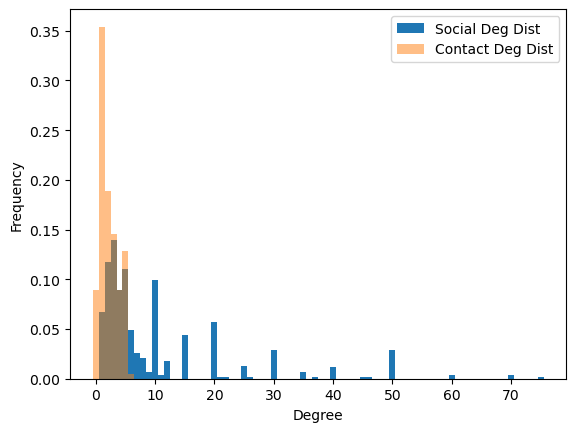

In [14]:
# Create bar plots for the distributions
index=76
plt.bar(range(0,index), padded_social_deg_dist[:index], width=1, label='Social Deg Dist', alpha=1)
plt.bar(range(0,index), padded_contact_deg_dist[:index], width=1, label='Contact Deg Dist', alpha=0.5)

# Add labels, title, and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()



## Sensitivity Analysis on Contact Degree Distribution

In [15]:
# contact_deg_dist_rightshift = {0 : 0.089, 1 : 0.354, 2 : 0.189, 3 : 0.146, 4 : 0.089, 5 : 0.1, 6:0.09, 7:0.08, 8:0.05, 9:0.04, 10:0.03}
# tot = sum(contact_deg_dist_rightshift.values())
# contact_deg_dist_rightshift = {k:v/tot for k,v in contact_deg_dist_rightshift.items()}
# data_rightshift = [contact_deg_dist_rightshift[k] for k in sorted(contact_deg_dist_rightshift)]

# contact_deg_dist_leftshift = {0 : 0.18, 1 : 0.7, 2 : 0.09, 3 : 0.07, 4 : 0.04, 5 : 0.02, 6 : 0.0, 7:0.00, 8:0, 9:0.000, 10:0}
# contact_deg_dist_leftshift = {k:v/tot for k,v in contact_deg_dist_older.items()}
# data_older = [contact_deg_dist_leftshift[k] for k in sorted(contact_deg_dist_older)]

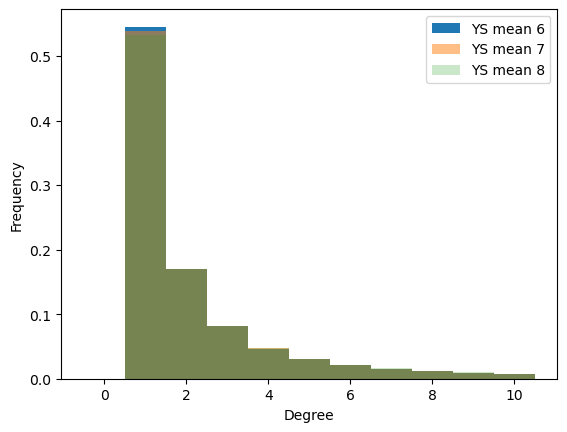

In [16]:
from scipy.stats import yulesimon

mean6_alpha,mean7_alpha,mean8_alpha = 1.20, 1.17, 1.14 
x = range(0,11)
plt.bar(x, yulesimon.pmf(x,mean6_alpha), width=1, label='YS mean 6', alpha=1)
plt.bar(x, yulesimon.pmf(x,mean7_alpha), width=1, label='YS mean 7', alpha=0.5)
plt.bar(x, yulesimon.pmf(x,mean8_alpha), width=1, label='YS mean 8', alpha=0.25)


# Add labels, title, and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()


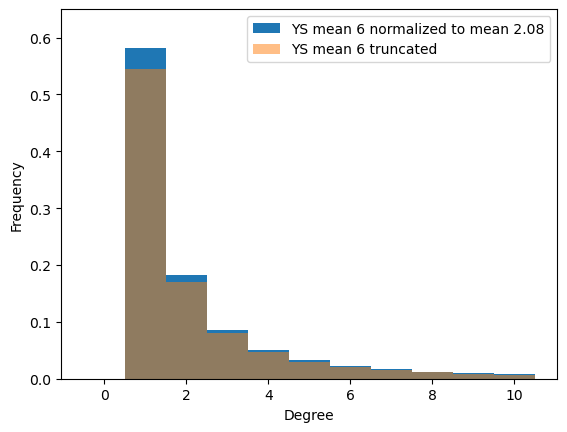

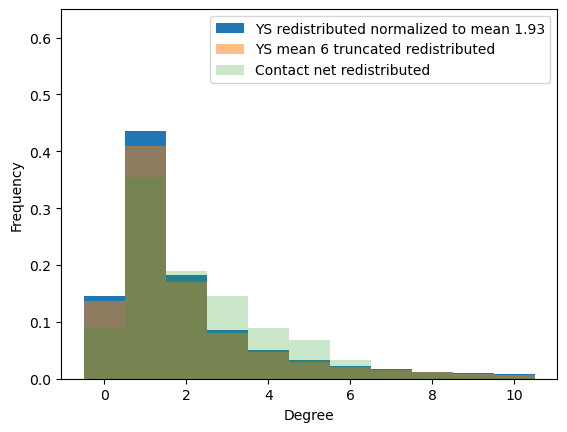

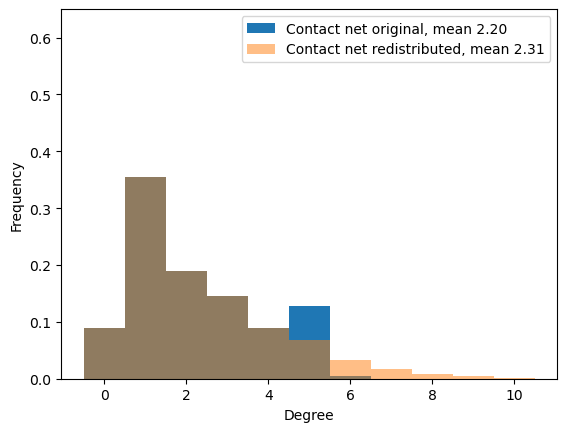

In [17]:

# try Yule-Simon distribution, which people have used before
# disadvantage 1: zero probability of zero sexual partners
# disadvantage 2: very fat tail -- unrealistic number of hub nodes

x = range(0,11)
y = yulesimon.pmf(x,mean6_alpha)

# plot original Yule-Simon distribution with mean 6 
yn = y/sum(y)
plt.bar(x, yn, width=1, label='YS mean 6 normalized to mean {:.2f}'.format(sum(yn*x)), alpha=1)

# plot original Yule-Simon distribution with mean 6 
plt.bar(x, y, width=1, label='YS mean 6 truncated', alpha=0.5)


# Add labels, title, and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.ylim([0,0.65])

plt.figure()

# redistribute 25% of the mass for degree 1 to degree 0 and renormalize
zero = y[1]*0.25
single = y[1]*0.75
yr = np.array([zero,single]+list(y[2:]))

# normalize redistribution to degree 10
ynr = yr/sum(yr)
plt.bar(x, ynr, width=1, label='YS redistributed normalized to mean {:.2f}'.format(sum(ynr*x)), alpha=1)
plt.bar(x, yr, width=1, label='YS mean 6 truncated redistributed', alpha=0.5)


# redistribute degrees 5 and 6 in the uConnect data to bins 5-10, decreasing 50% each time
contact_deg_dist_distributed = np.array([0.089, 0.354, 0.189, 0.146, 0.089, 0.0676, 0.0338, 0.0169, 0.0085, 0.0042, 0.0021])
plt.bar(x, contact_deg_dist_distributed, width=1, label='Contact net redistributed', alpha=0.25)

# Add labels, title, and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.ylim([0,0.65])

plt.figure()

# plot original and redistributed uConnect data
contact_deg_dist = np.array([0.089, 0.354, 0.189, 0.146, 0.089, 0.128, 0.005, 0, 0, 0, 0])
plt.bar(x, contact_deg_dist,width=1, label='Contact net original, mean {:.2f}'.format(sum(contact_deg_dist*x)), alpha=1)
plt.bar(x, contact_deg_dist_distributed, width=1, label='Contact net redistributed, mean {:.2f}'.format(sum(contact_deg_dist_distributed*x)), alpha=0.5)

# Add labels, title, and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.ylim([0,0.65])

# add hub nodes -- need stats on this
contact_deg_dist_distributed_hubs = np.array(list(contact_deg_dist_distributed)+[0]*10+[.0001] + [0]*40 + [.0001] + [0]*100 + [.0001] + [0]*400 + [.00001])
